# The classification tasks consist in predicting the activity performed by the user from sensor data generated by a Wireless Sensor Network (WSN).
 
## We will be classifying the activity performed by the user based on the sensor data, e.g. bending, sitting, cycling etc


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.sql.functions import lit
from functools import reduce 
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType
import pandas as pd
import os
import glob

### Since there are multiple datasets, each pertaining to one class, we will read each one of them create 1 dataframe

In [3]:
myfile = os.listdir('AReM')
myfile = list(myfile)
path1 = []
for items in myfile:
    path1.append('AReM/' + items)

# Creating a list which will contain all the path of csvs

csv_list = []
for i in range(len(path1)):
    csv_list.append(glob.glob(path1[i] + "/*.csv"))
    
# Creating a blank dictionary to store label wise paths

df_csv = {}

for i in myfile:
    df_csv[i] = None
    
for key, val in zip(df_csv, csv_list):
    df_csv[key] = val

df = pd.DataFrame(columns = pd.read_csv(df_csv['bending1'][0], on_bad_lines = 'skip', skiprows = 4).columns) #Creating blank dataframe
for key in df_csv:
    for i in range(len(df_csv[key])):
        temp = pd.read_csv(df_csv[key][i], on_bad_lines='skip', skiprows = 4)
        temp['label'] = key                                                 # Here, keys are the dataset names which are classes as well
        df = pd.concat([df, temp])

/tmp/ipykernel_8839/1581229319.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp])


### Using PySpark to continue with EDA and modeling

In [4]:
spark = SparkSession.builder.appName("AReM").getOrCreate()
df = spark.createDataFrame(df)

df.show()

23/11/10 18:50:59 WARN Utils: Your hostname, localhost.localdomain resolves to a loopback address: 127.0.0.1; using 10.21.11.100 instead (on interface eth0)
23/11/10 18:50:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/10 18:51:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/student/miniconda3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+---------------+---------+---------+---------+---------+---------+---------+-------+
|# Columns: time|avg_rss12|var_rss12|avg_rss13|var_rss13|avg_rss23|var_rss23|  label|
+---------------+---------+---------+---------+---------+---------+---------+-------+
|              0|    41.75|     1.79|     8.75|     6.87|    23.25|     0.83|cycling|
|            250|     39.5|     3.57|     15.0|      0.0|    19.25|     3.27|cycling|
|            500|     35.0|     1.41|    19.33|     1.25|     19.5|      3.2|cycling|
|            750|     36.0|      0.0|     18.5|      0.5|    21.25|     4.76|cycling|
|           1000|    33.33|     2.87|    20.25|     1.79|    23.75|     0.43|cycling|
|           1250|     38.5|      1.5|    18.67|     2.62|    22.33|      1.7|cycling|
|           1500|    41.25|     1.92|    11.33|      1.7|    22.33|     0.94|cycling|
|           1750|     40.5|      3.2|     13.0|     2.16|     13.5|     4.56|cycling|
|           2000|     34.0|     1.41|    17.75|      3

In [5]:
df.printSchema()

root
 |-- # Columns: time: string (nullable = true)
 |-- avg_rss12: double (nullable = true)
 |-- var_rss12: double (nullable = true)
 |-- avg_rss13: double (nullable = true)
 |-- var_rss13: double (nullable = true)
 |-- avg_rss23: double (nullable = true)
 |-- var_rss23: double (nullable = true)
 |-- label: string (nullable = true)



In [6]:
df.describe().show()

23/11/10 18:51:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+---------+---------+---------+---------+---------+---------+--------+
|summary|     # Columns: time|avg_rss12|var_rss12|avg_rss13|var_rss13|avg_rss23|var_rss23|   label|
+-------+--------------------+---------+---------+---------+---------+---------+---------+--------+
|  count|               42237|    42237|    42237|    42237|    42237|    42237|    42237|   42237|
|   mean|   59873.24280958881|      NaN|      NaN|      NaN|      NaN|      NaN|      NaN|    NULL|
| stddev|   34639.37822872943|      NaN|      NaN|      NaN|      NaN|      NaN|      NaN|    NULL|
|    min|                   0|      0.0|      0.0|      0.0|      0.0|      0.0|      0.0|bending1|
|    max|99750 29.00 0.00 ...|      NaN|      NaN|      NaN|      NaN|      NaN|      NaN| walking|
+-------+--------------------+---------+---------+---------+---------+---------+---------+--------+



## Precprocessing the dataset.

In [7]:
# Do we have null or blanks?

null_counts = [F.sum(F.col(column).isNull().cast('int')).alias(column) for column in df.columns]

# Use select to display the null counts
df.select(null_counts).show()

+---------------+---------+---------+---------+---------+---------+---------+-----+
|# Columns: time|avg_rss12|var_rss12|avg_rss13|var_rss13|avg_rss23|var_rss23|label|
+---------------+---------+---------+---------+---------+---------+---------+-----+
|              0|        0|        0|        0|        0|        0|        0|    0|
+---------------+---------+---------+---------+---------+---------+---------+-----+



Change the name of the first column to time

In [8]:
df = df.withColumnRenamed("# Columns: time", "time")

### Since it is a classification problem, we dont need this column, hence dropping it.

In [9]:
df = df.drop("time")

In [10]:
# Dropping null values

columns_to_check = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

# Drop rows with missing values in the specified columns
df = df.dropna(subset=columns_to_check)

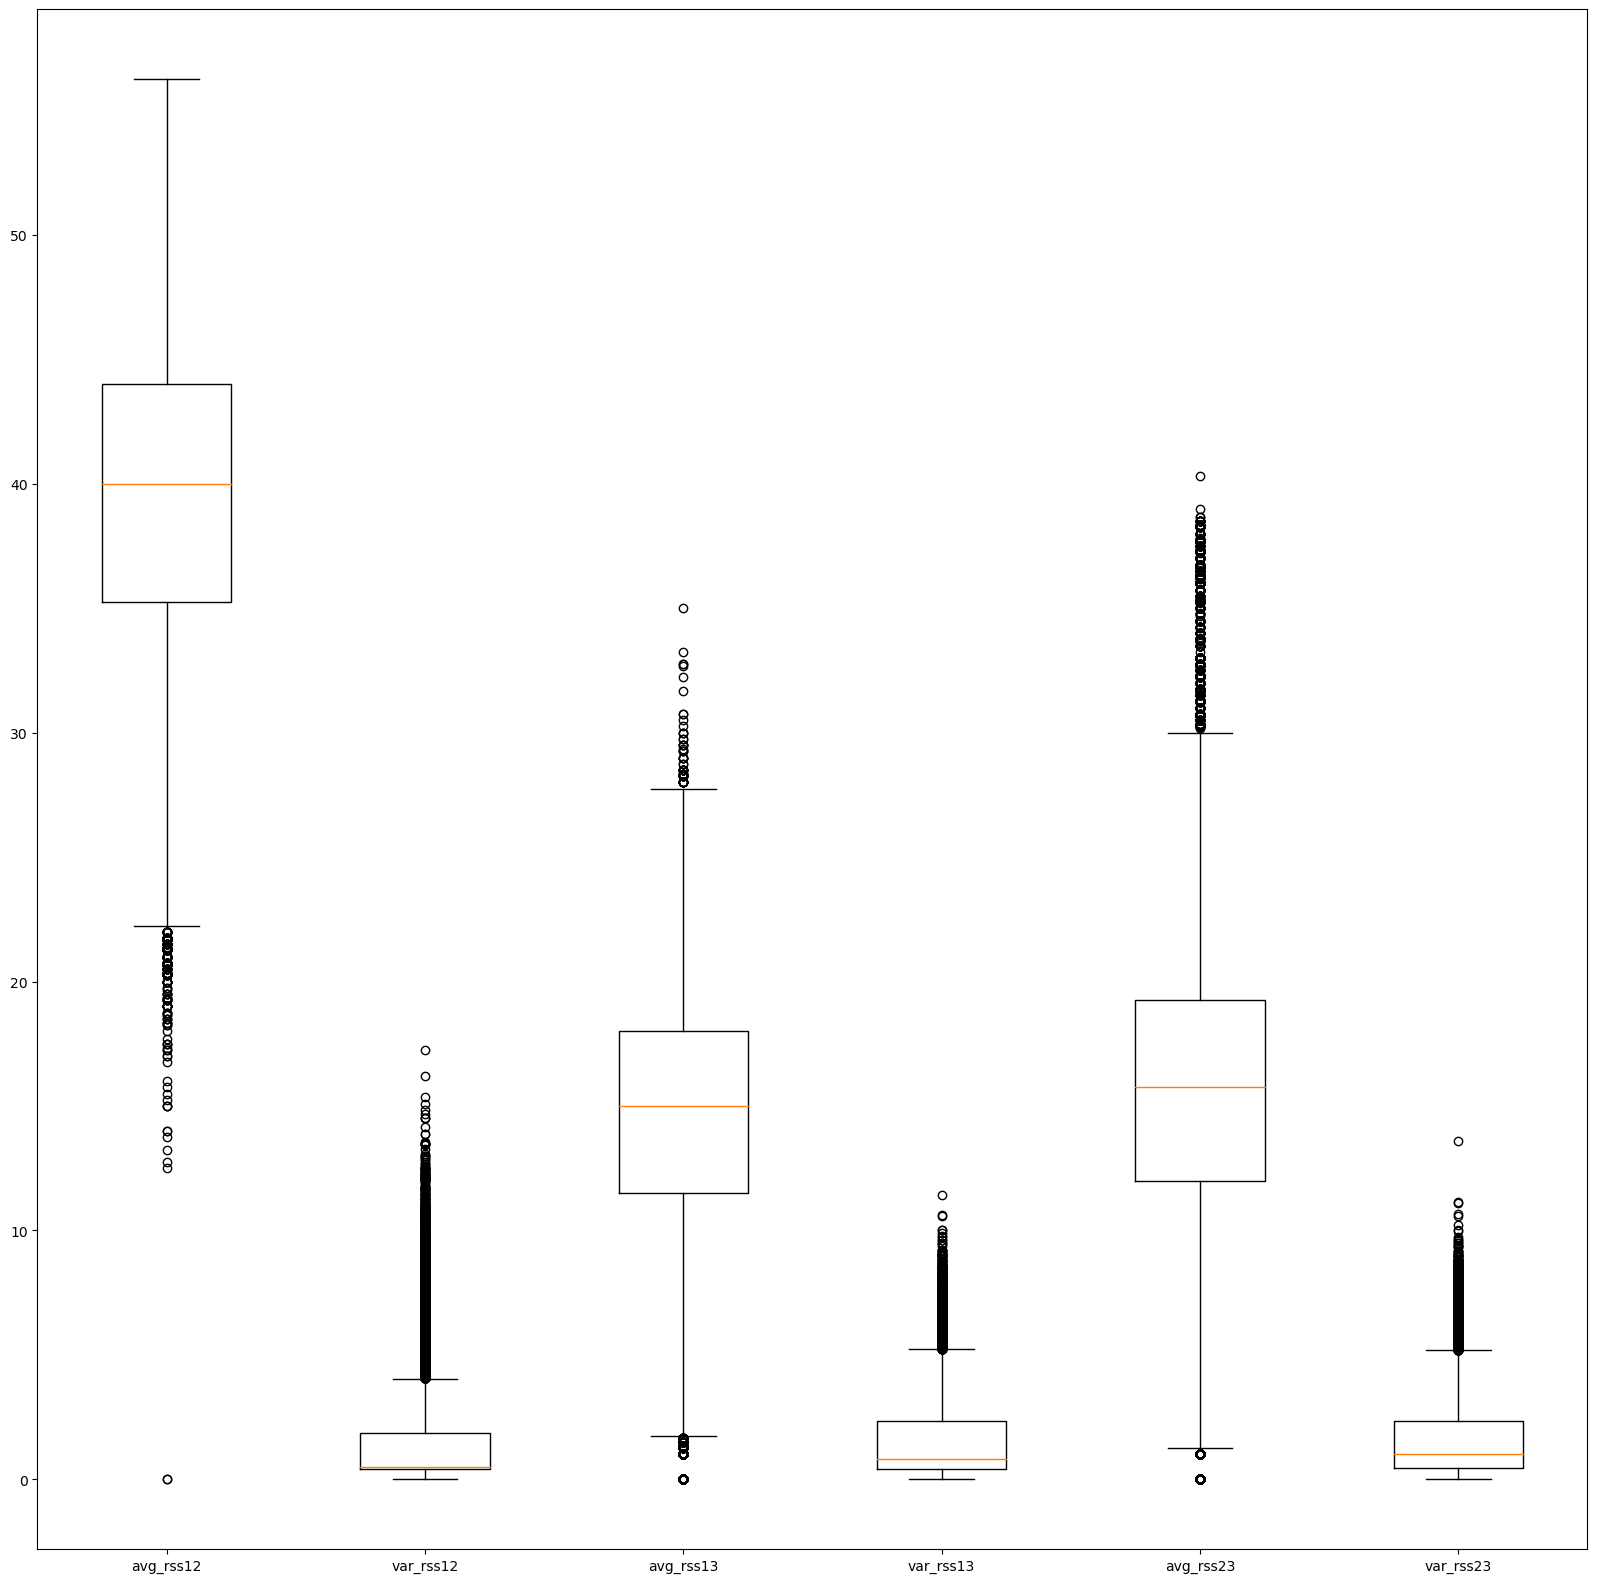

In [11]:
# Plotting each column and looking for abnormality

# Specify the columns you want to create boxplots for
boxplot_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

# Create a list of lists containing the data for each boxplot column
boxplot_data = [df.select(col(column).cast('double')).rdd.flatMap(lambda x: x).collect() for column in boxplot_columns]

# Create the boxplot
fig, ax = plt.subplots(figsize=(20, 20))
ax.boxplot(boxplot_data)
ax.set_xticklabels(boxplot_columns)

# Show the boxplot
plt.show()

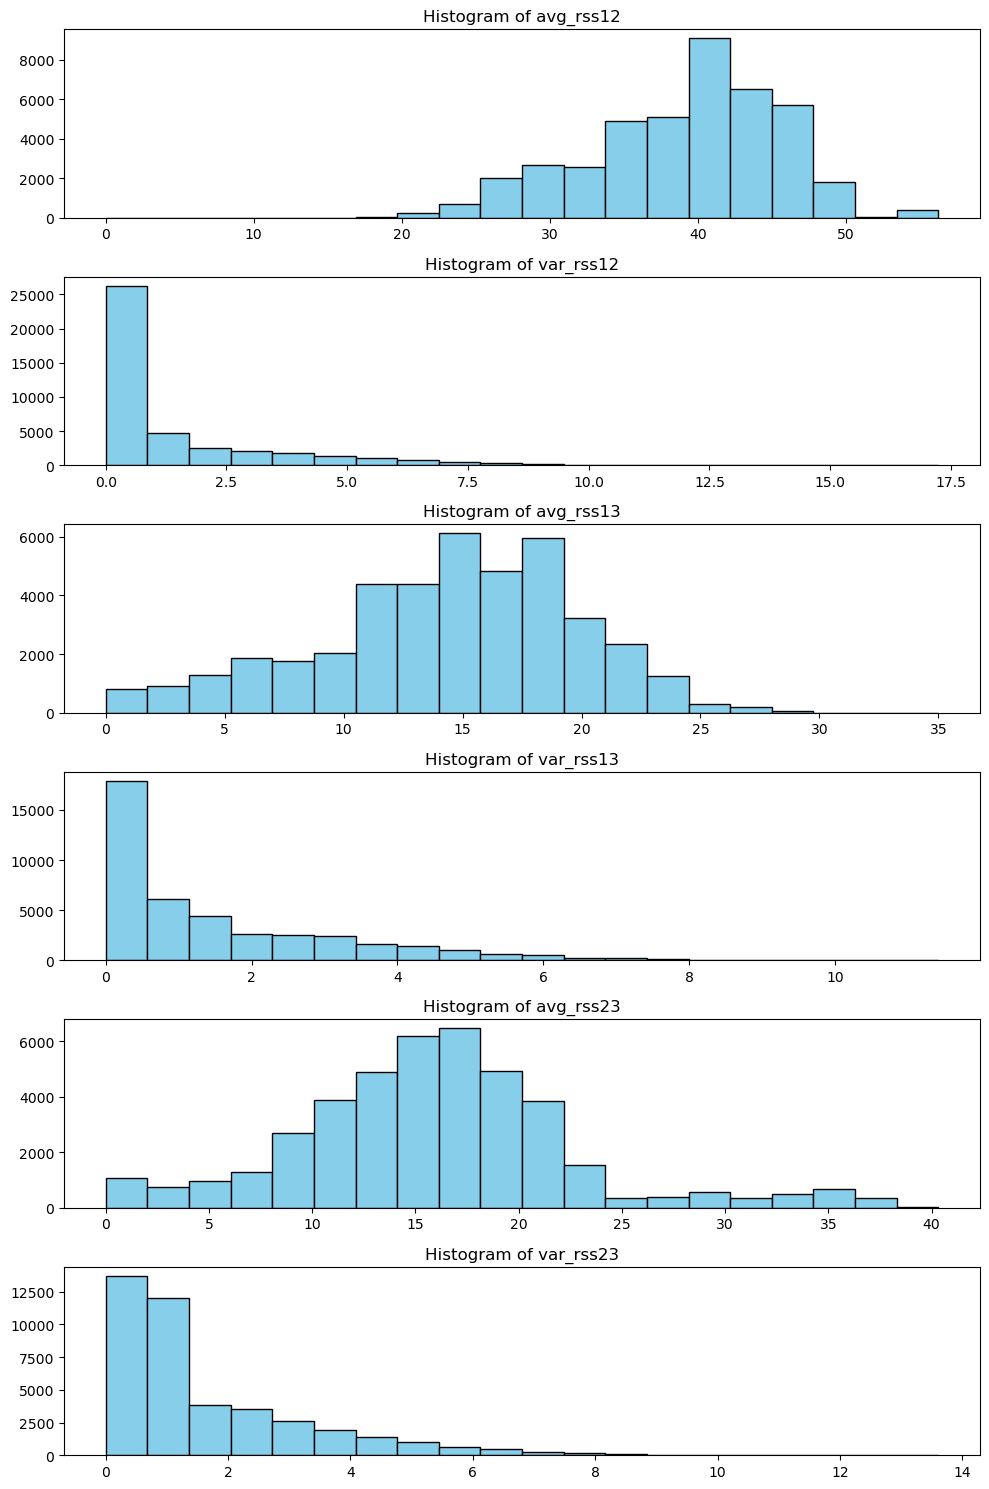

In [12]:
# Specify the columns you want to create histograms for
histogram_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

# Create subplots for histograms
fig, axs = plt.subplots(nrows=len(histogram_columns), figsize=(10, 15))

# Create histograms for each column
for i, column in enumerate(histogram_columns):
    axs[i].hist(df.select(col(column).cast('double')).rdd.flatMap(lambda x: x).collect(), bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Histogram of {column}')

plt.tight_layout()
plt.show()


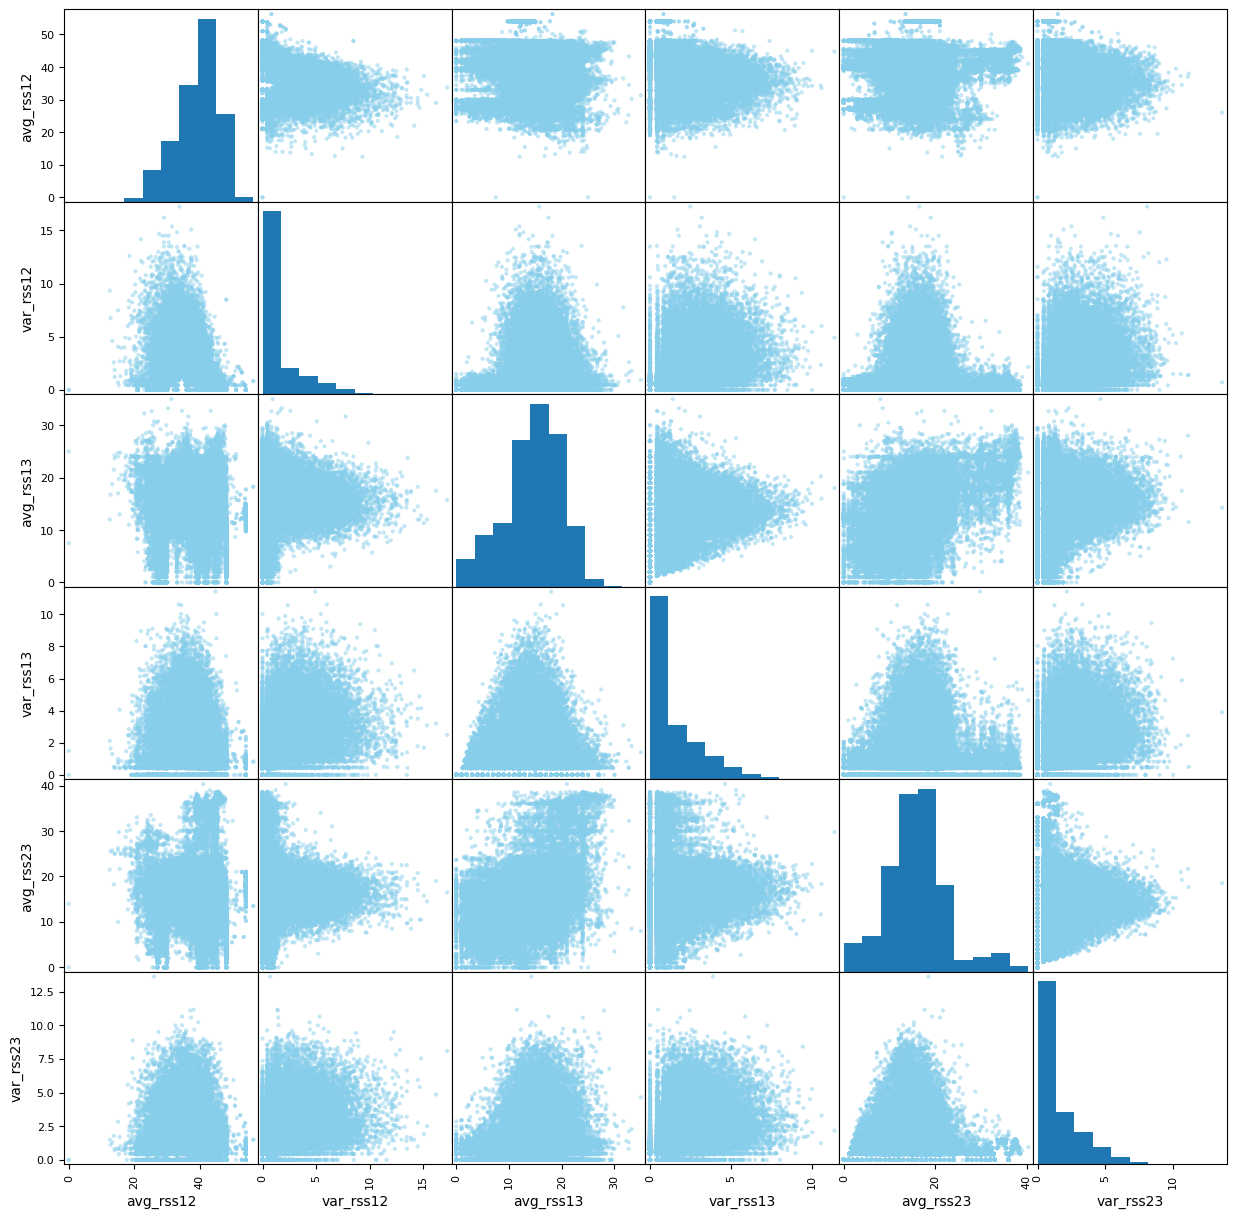

In [14]:
from pandas.plotting import scatter_matrix

# Specify the columns you want to create a scatter plot matrix for
scatter_columns = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

# Select the specified columns and convert to Pandas DataFrame
scatter_df = df.select(*scatter_columns).toPandas()

# Create scatter plot matrix
scatter_matrix(scatter_df, figsize=(15, 15), diagonal='hist', color='skyblue')
plt.show()


In [13]:
df.write.csv('data.csv', header = True, mode = 'overwrite')